In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [40]:
# generating cosine with noise dataset
time = np.arange(0, 200, 0.1)
cos = np.cos(time) + np.random.normal(scale=0.5, size=len(time))

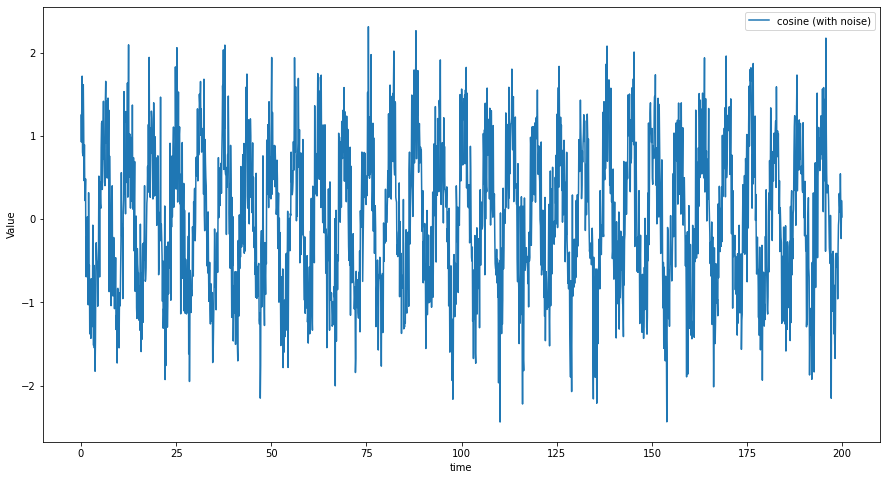

In [41]:
plt.plot(time, cos, label='cosine (with noise)')
plt.ylabel('Value')
plt.xlabel('time')
plt.legend()
plt.show()

# Data Preprocessing

In [42]:
df = pd.DataFrame(cos, index=time, columns=['cosine'])
df.head()

,cosine
0.0,1.248357
0.1,0.925872
0.2,1.303911
0.3,1.716851
0.4,0.803984


In [52]:
df_size = df.shape[0]
train = df.iloc[ : int(df_size * 0.70)]
validation = df.iloc[int(df_size * 0.70) : int(df_size * 0.85)]
test = df.iloc[int(df_size * 0.85) : ]

train.shape, validation.shape, test.shape

((1400, 1), (300, 1), (300, 1))

In [53]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(0,(X.shape[0] - time_steps),1):
        Xs.append(X.iloc[i:(i + time_steps)].values)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [67]:
time_steps = 20

X_train, y_train = create_dataset(train, train.cosine, time_steps)
X_validation, y_validation = create_dataset(validation, validation.cosine, time_steps)
X_test, y_test = create_dataset(test, test.cosine, time_steps)

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((1380, 20, 1), (1380,), (280, 20, 1), (280,), (280, 20, 1), (280,))

# Modeling

In [68]:
# LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape= (X_train.shape[1], X_train.shape[2]),
                                    return_sequences = False))
                                
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10)
model.compile(loss = tf.losses.MeanSquaredError(),
                optimizer = tf.optimizers.Adam(),
                metrics = [tf.metrics.MeanAbsoluteError()])

history = model.fit(X_train, y_train, epochs=200,
                    validation_data=[X_validation, y_validation],
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping])

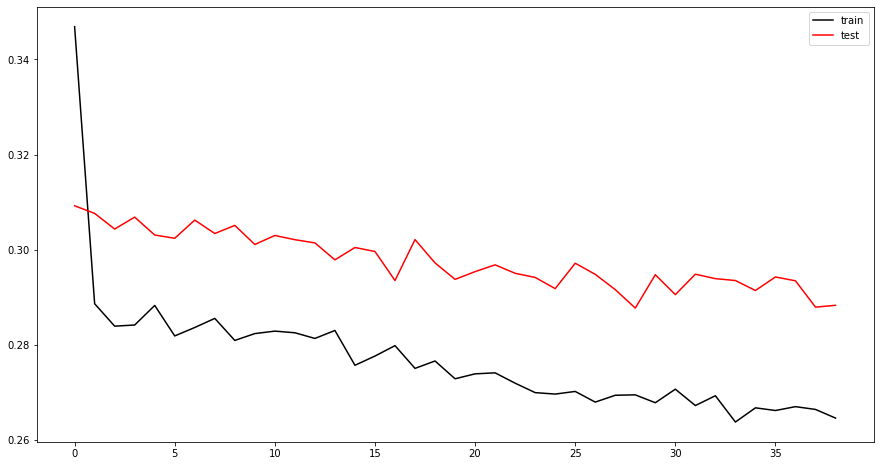

In [69]:
plt.plot(history.history['loss'], label='train', color = 'black')
plt.plot(history.history['val_loss'], label='test', color = 'red')
plt.legend()
plt.show()

In [70]:
y_pred = model.predict(X_test)

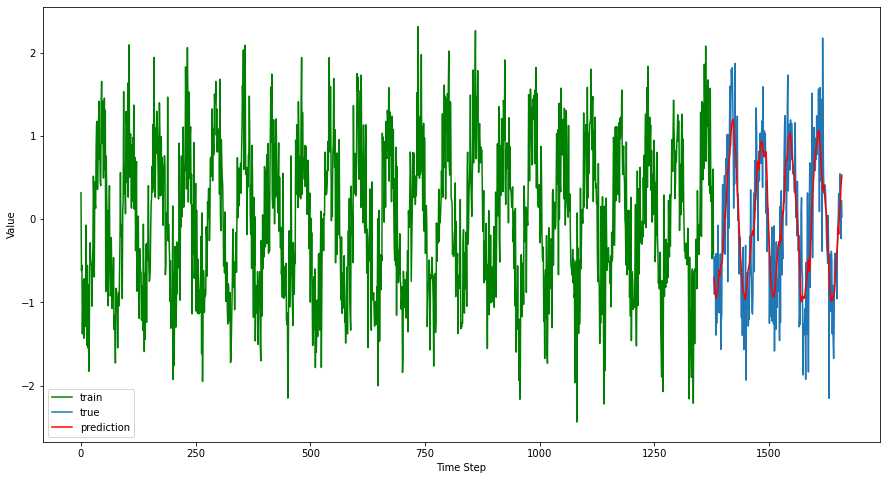

In [73]:
plt.plot(np.arange(0, len(y_train)), y_train, color = 'green', label="train")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, color = 'red', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

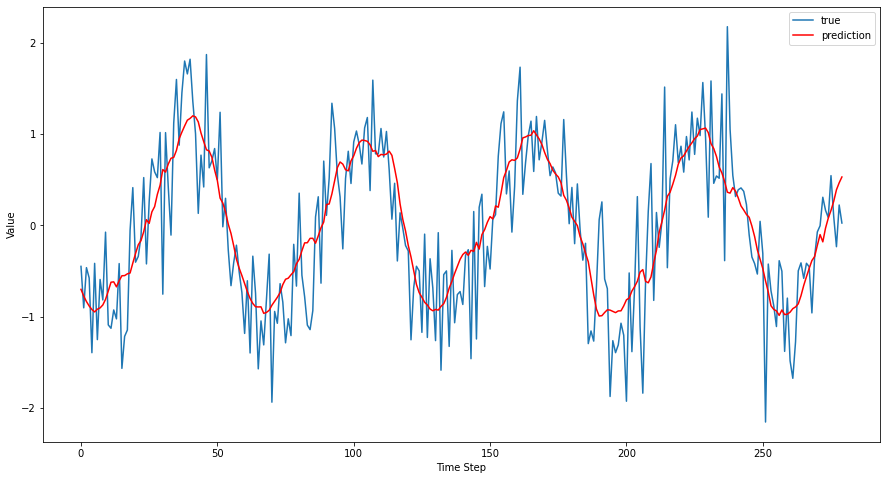

In [74]:
plt.plot(y_test, label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()